# Group Project
## Sports Analytics
---


**Load List of Active GMs**

In [1]:
import pandas as pd
gm = pd.read_csv('~/Documents/Fordham/Sports Analytics/nbaGMscorer/activeGMsV2.txt',sep='\t')

In [2]:
gm.head()

,Team,General Manager,Date of hire,Active,URL
0,Atlanta Hawks,Travis Schlenk,2017,Y,http://www.prosportstransactions.com/basketbal...
1,Boston Celtics,Danny Ainge,2003,Y,http://www.prosportstransactions.com/basketbal...
2,Brooklyn Nets,Sean Marks,2016,Y,http://www.prosportstransactions.com/basketbal...
3,Charlotte Hornets,Rich Cho,2011,Y,http://www.prosportstransactions.com/basketbal...
4,Chicago Bulls,Gar Forman,2009,Y,http://www.prosportstransactions.com/basketbal...


Text(0.5,1,'Count of GMs by Hired Date')

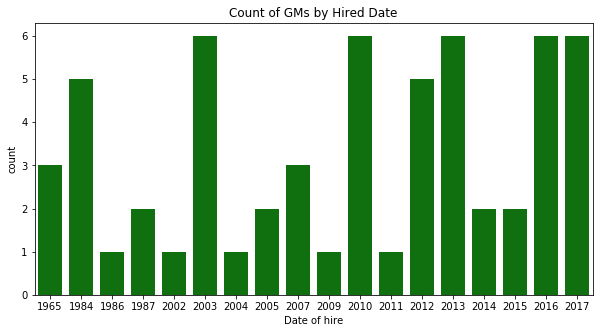

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
gmCnt = sns.countplot(x="Date of hire", data=gm,color='green')
gmCnt.set_title("Count of GMs by Hired Date")

Text(0.5,1,'Count of Active GMs by Hired Date')

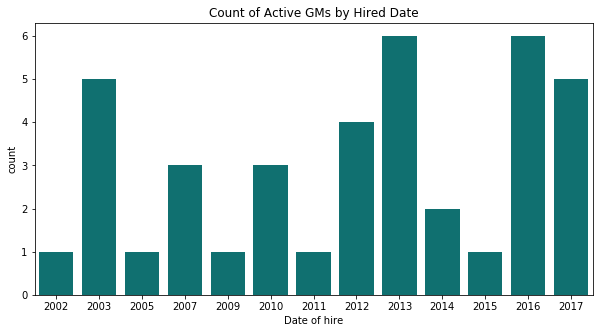

In [80]:
gmNew = gm[(gm["Active"]=="Y")]
plt.figure(figsize=(10,5))
gmCnt = sns.countplot(x="Date of hire", data=gmNew,color='teal')
gmCnt.set_title("Count of Active GMs by Hired Date")

---
## Scrape Transactions

Transactions for each active GM were scraped in order to determine the transactions for which the GM / executive was responsible for.
* *Note*: the role of the general manager can be very different for each franchise and sometimes the personnel decisions are not solely made by the GM
* Data was sourced from http://www.prosportstransactions.com
* Only contains GMs active as of *March 4th 2018*

In [5]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import urllib.request
import re
import requests
import pprint
class AppURLopener(urllib.request.FancyURLopener):
    version = "Mozilla/5.0"

In [6]:
def gmScrape(gmName,URL):
        query = (URL)
        opener = AppURLopener()
        response = opener.open(query)
        soup = BeautifulSoup(response,'html.parser')
        urlList = []
        for tr in soup.find_all('tr')[-1:]:
            tds = tr.find_all('a')
            for x in tds[:-1]:
                urlList.append(str(URL[:-1])+str(int(x.text)*25))
        info = soup.find('table',{'class':'datatable center'})
        date = []
        team = []
        acquired = []
        relinquished = []
        notes = []
        for tr in soup.find_all('tr')[2:-1]:
            tds = tr.find_all('td')
            date.append(tds[0].text)
            team.append(tds[1].text)
            acquired.append(tds[2].text)
            relinquished.append(tds[3].text)
            notes.append(tds[4].text)
        for y in urlList:
            query = (str(y))
            opener = AppURLopener()
            response = opener.open(query)
            soup = BeautifulSoup(response,'html.parser')
            for tr in soup.find_all('tr')[1:-1]:
                tds = tr.find_all('td')
                date.append(tds[0].text)
                team.append(tds[1].text)
                acquired.append(tds[2].text)
                relinquished.append(tds[3].text)
                notes.append(tds[4].text)
        df1 = pd.DataFrame({'date':date,
                     'team': team,
                     'acquired':acquired,
                     'relinquished':relinquished,
                     'notes':notes})
        df1['GM'] = gmName
        return(df1)

In [7]:
finalDat = pd.DataFrame()
for genM,urlEach in zip(gm['General Manager'],gm['URL']):
    if str(urlEach).lower()=="nan":
        pass
    else:
        dat = gmScrape(str(genM),str(urlEach))
        finalDat = pd.concat([finalDat,dat])
        finalDat.reset_index()

C:\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: AppURLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: AppURLopener style of invoking requests is deprecated. Use newer urlopen functions/methods


In [8]:
finalDat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14005 entries, 0 to 73
Data columns (total 6 columns):
acquired        14005 non-null object
date            14005 non-null object
notes           14005 non-null object
relinquished    14005 non-null object
team            14005 non-null object
GM              14005 non-null object
dtypes: object(6)
memory usage: 765.9+ KB


In [9]:
finalDat.head()

,acquired,date,notes,relinquished,team,GM
0,• Marco Belinelli• Miles Plumlee• 2017 second...,2017-06-20,trade with Hornets,• Dwight Howard• 2017 second round pick (#31-...,Hawks,Travis Schlenk
1,• Alpha Kaba,2017-06-22,2017 NBA draft second round pick (#60 overall),,Hawks,Travis Schlenk
2,• John Collins (b),2017-06-22,2017 NBA draft first round pick (#19 overall),,Hawks,Travis Schlenk
3,• Tyler Dorsey,2017-06-22,2017 NBA draft second round pick (#41 overall),,Hawks,Travis Schlenk
4,• Tim Hardaway Jr.,2017-06-26,"team tendered $4.6M qualifying offer, making ...",,Hawks,Travis Schlenk


---
# Clean Columns for Analysis

* Remove special characters from acquired column
* normalize the transactions

Text(0.5,1,'Count of Transaction by GM')

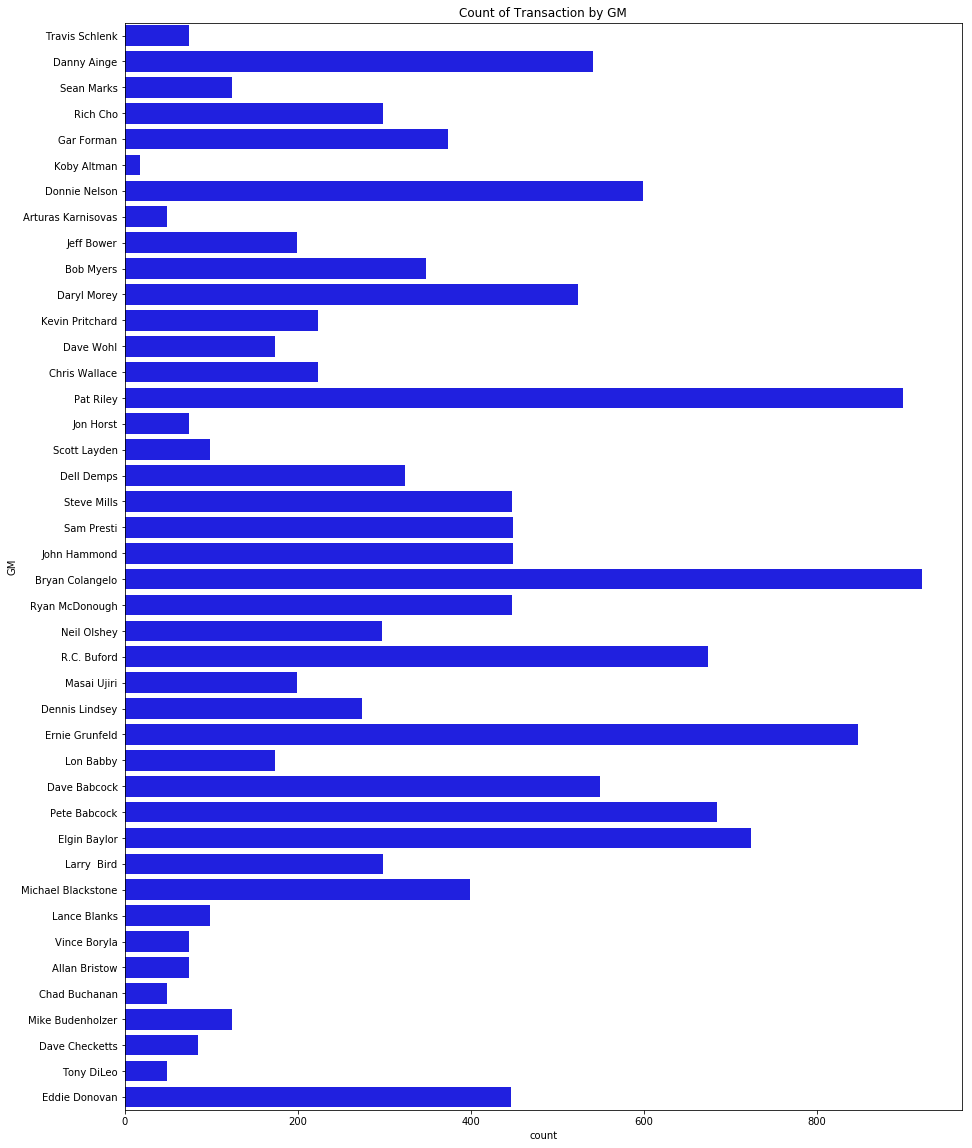

In [10]:
plt.figure(figsize=(15,20))
finalDat.groupby(finalDat['GM']).count()
gmCnt2 = sns.countplot(y='GM', data=finalDat,color='blue')
gmCnt2.set_title("Count of Transaction by GM")

#### Top 5 active GMs

Text(0.5,1,'Count of Transaction by Executive')

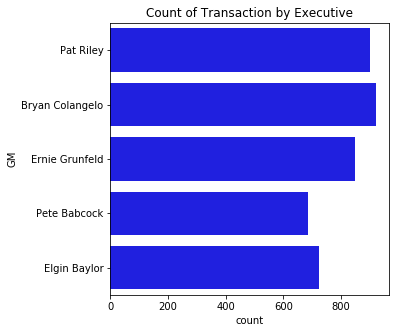

In [22]:
plt.figure(figsize=(5,5))
# newFin = finalDat.groupby(finalDat['GM']).count().sort_values("team",ascending=False).reset_index().head()

topGmsTransactions = ("Bryan Colangelo","Pat Riley","Ernie Grunfeld","Elgin Baylor", "Pete Babcock")
newFin = finalDat[(finalDat["GM"].isin(topGmsTransactions))]
# newFin.info()
# newFin.sort_values("count",ascending=False)
# newFin.sort_values("team",ascending=False)
gmCnt2 = sns.countplot(y='GM', data=newFin,color='blue')
gmCnt2.set_title("Count of Transaction by Executive")

#### Clean Players Columns

In [23]:
finalDat.head()

,acquired,date,notes,relinquished,team,GM
0,• Marco Belinelli• Miles Plumlee• 2017 second...,2017-06-20,trade with Hornets,• Dwight Howard• 2017 second round pick (#31-...,Hawks,Travis Schlenk
1,• Alpha Kaba,2017-06-22,2017 NBA draft second round pick (#60 overall),,Hawks,Travis Schlenk
2,• John Collins (b),2017-06-22,2017 NBA draft first round pick (#19 overall),,Hawks,Travis Schlenk
3,• Tyler Dorsey,2017-06-22,2017 NBA draft second round pick (#41 overall),,Hawks,Travis Schlenk
4,• Tim Hardaway Jr.,2017-06-26,"team tendered $4.6M qualifying offer, making ...",,Hawks,Travis Schlenk


In [24]:
newDat = finalDat
newDat['acquired'] = newDat['acquired'].astype('str').str.replace('•','|').str.strip().map(lambda x: x.split('|')[1:])
newDat['relinquished'] = newDat['relinquished'].astype('str').str.replace('•','|').str.strip().map(lambda x: x.split('|')[1:])
newDat.head()

,acquired,date,notes,relinquished,team,GM
0,"[ Marco Belinelli, Miles Plumlee, 2017 secon...",2017-06-20,trade with Hornets,"[ Dwight Howard, 2017 second round pick (#31-...",Hawks,Travis Schlenk
1,[ Alpha Kaba],2017-06-22,2017 NBA draft second round pick (#60 overall),[],Hawks,Travis Schlenk
2,[ John Collins (b)],2017-06-22,2017 NBA draft first round pick (#19 overall),[],Hawks,Travis Schlenk
3,[ Tyler Dorsey],2017-06-22,2017 NBA draft second round pick (#41 overall),[],Hawks,Travis Schlenk
4,[ Tim Hardaway Jr.],2017-06-26,"team tendered $4.6M qualifying offer, making ...",[],Hawks,Travis Schlenk


#### Classify transaction types and build flags

In [26]:
newDat['drafted'] = newDat['notes'].map(lambda x: x.lower()).str.contains('pick')
newDat['traded'] = newDat['notes'].map(lambda x: x.lower()).str.contains('trade')
newDat['signed'] = (newDat['acquired'].map(lambda x: len(x)) >= 1) & (newDat['relinquished'].map(lambda x: len(x)) == 0) & (newDat['notes'].map(lambda x: x.lower()).str.contains('pick')==False)
newDat['released'] = (newDat['acquired'].map(lambda x: len(x)) == 0) & (newDat['relinquished'].map(lambda x: len(x)) >= 1)
newDat['DraftPickNo'] = newDat['notes'].map(lambda x: x.lower()).str.extract('#(.\d)',expand=False)                                                                    

In [27]:
newDatClassified = newDat[(newDat['signed']==True) | (newDat['traded']==True) | (newDat['released']==True) | (newDat['drafted']==True)] 

In [28]:
len(newDatClassified)

13939

In [29]:
newDatClassified.head(3).T

,0,1,2
acquired,"[ Marco Belinelli, Miles Plumlee, 2017 secon...",[ Alpha Kaba],[ John Collins (b)]
date,2017-06-20,2017-06-22,2017-06-22
notes,trade with Hornets,2017 NBA draft second round pick (#60 overall),2017 NBA draft first round pick (#19 overall)
relinquished,"[ Dwight Howard, 2017 second round pick (#31-...",[],[]
team,Hawks,Hawks,Hawks
GM,Travis Schlenk,Travis Schlenk,Travis Schlenk
drafted,False,True,True
traded,True,False,False
signed,False,False,False
released,False,False,False


#### Develop summary statistics for transaction volume based on transaction type

In [31]:
# expand df.listcol into its own dataframe
# tags = newDatClassified['acquired'].apply(pd.Series)
final = newDatClassified.join(newDatClassified.acquired.apply(pd.Series)
                          .stack()
                          .reset_index(level=1, drop=True)
                          .to_frame('acquired'),rsuffix='keep_')

In [32]:
final.head(3)

,acquired,date,notes,relinquished,team,GM,drafted,traded,signed,released,DraftPickNo,acquiredkeep_
0,"[ Marco Belinelli, Miles Plumlee, 2017 secon...",2017-06-20,trade with Hornets,"[ Dwight Howard, 2017 second round pick (#31-...",Hawks,Travis Schlenk,False,True,False,False,NaN,Marco Belinelli
0,"[ Marco Belinelli, Miles Plumlee, 2017 secon...",2017-06-20,trade with Hornets,"[ Dwight Howard, 2017 second round pick (#31-...",Hawks,Travis Schlenk,False,True,False,False,NaN,Miles Plumlee
0,"[ Marco Belinelli, Miles Plumlee, 2017 secon...",2017-06-20,trade with Hornets,"[ Dwight Howard, 2017 second round pick (#31-...",Hawks,Travis Schlenk,False,True,False,False,NaN,2017 second round pick (#41-Tyler Dorsey)


In [44]:
final['transaction count'] =1       #initially, set that counter to 1.
group_data = final.groupby(['GM','drafted','traded','signed','released'])['transaction count'].sum() 
group_data.head()

GM                  drafted  traded  signed  released
Allan Bristow       False    False   False   True         784
                                     True    False       1748
                    True     False   False   False        513
Arturas Karnisovas  False    False   False   True         213
                                     True    False       1230
Name: transaction count, dtype: int64

In [54]:
import numpy as np
finalTmp = final.groupby(['GM','drafted','traded','signed','released'], as_index=False).sum()
# finalTmp.head()
# Drafted
finalTmp['drafted'] = np.where(finalTmp['drafted'] == True, finalTmp['transaction count'], finalTmp['drafted'])
finalTmp['drafted'] = np.where(finalTmp['drafted'] == False, 0, finalTmp['drafted'])

# Traded
finalTmp['signed'] = np.where(finalTmp['signed'] == True, finalTmp['transaction count'], finalTmp['signed'])
finalTmp['signed'] = np.where(finalTmp['signed'] == False, 0, finalTmp['signed'])

# Signed
finalTmp['traded'] = np.where(finalTmp['traded'] == True, finalTmp['transaction count'], finalTmp['traded'])
finalTmp['traded'] = np.where(finalTmp['traded'] == False, 0, finalTmp['traded'])

# Released
finalTmp['released'] = np.where(finalTmp['released'] == True, finalTmp['transaction count'], finalTmp['released'])
finalTmp['released'] = np.where(finalTmp['released'] == False, 0, finalTmp['released'])
# finalTmp.head()


finalTmp2 = pd.melt(finalTmp, id_vars=['GM'], value_vars=['drafted','traded','signed','released'],var_name='type', value_name='cnt')
finalTmp2.drop_duplicates(inplace=True)
# finalTmp2.head()

finalTmp3 = finalTmp2[(finalTmp2['cnt']>0)]
finalTmp3.head()

,GM,type,cnt
2,Allan Bristow,drafted,513
6,Arturas Karnisovas,drafted,443
10,Bob Myers,drafted,2404
14,Bryan Colangelo,drafted,2722
18,Chad Buchanan,drafted,245


Text(0.5,1,'Transaction Volume by Type')

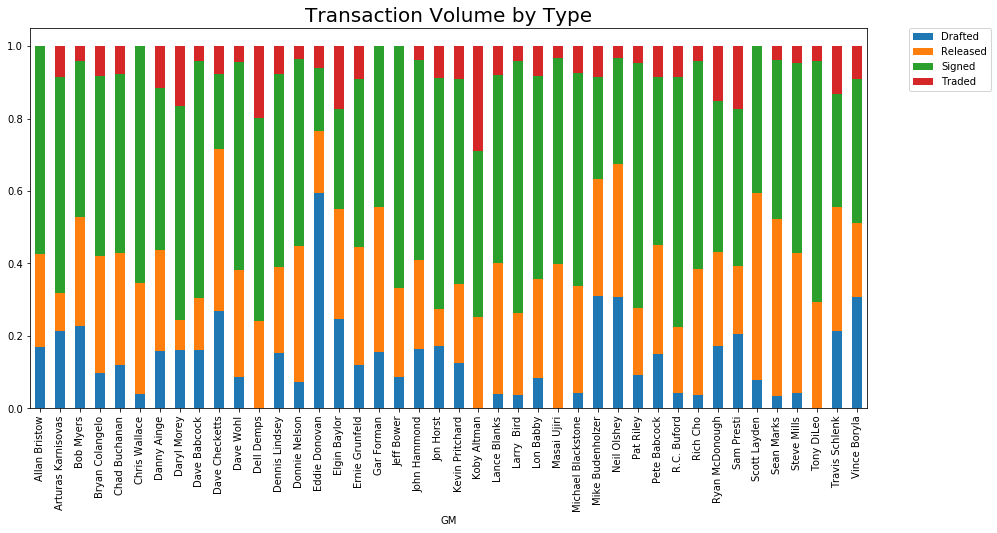

In [79]:
from matplotlib.pyplot import *
tps = finalTmp3.pivot_table(values=['cnt'], 
                      index='GM',
                      columns='type',
                      aggfunc='sum')

tps = tps.div(tps.sum(1), axis=0)
tps.plot(kind='bar', stacked=True,figsize=(15,7))
legend(labels = ('Drafted','Released','Signed','Traded'),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Transaction Volume by Type",fontsize = 20)

---
## Player Statistics
* **Source**: https://www.kaggle.com/drgilermo/nba-players-stats/data
* Each row is a player and year

In [81]:
baseStats = pd.read_csv('~/Documents/Fordham/Sports Analytics/nbaGMscorer/season_stats.csv',sep=',')

In [82]:
baseStats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24691 entries, 0 to 24690
Data columns (total 53 columns):
Unnamed: 0    24691 non-null int64
Year          24624 non-null float64
Player        24624 non-null object
Pos           24624 non-null object
Age           24616 non-null float64
Tm            24624 non-null object
G             24624 non-null float64
GS            18233 non-null float64
MP            24138 non-null float64
PER           24101 non-null float64
TS%           24538 non-null float64
3PAr          18839 non-null float64
FTr           24525 non-null float64
ORB%          20792 non-null float64
DRB%          20792 non-null float64
TRB%          21571 non-null float64
AST%          22555 non-null float64
STL%          20792 non-null float64
BLK%          20792 non-null float64
TOV%          19582 non-null float64
USG%          19640 non-null float64
blanl         0 non-null float64
OWS           24585 non-null float64
DWS           24585 non-null float64
WS          

#### Win Shares
* Descriptive statistics
* Histrogram (all seasons after 2010)

> **What is win share?** <br>
Win share is composed of 2 aggregate measures for both offense and defense.
<br>
<br>
*Offensive win shares* are derived from 4 components:
1. Calculate points produced per player
2. Calculate offensive posessions
3. Calculate marginal offense for each player
4. Calculate marginal points per win
5. Credit offensive win shares to the players
<br>
<br>
*Defensive win shares* are derived from 4 components:
1. Calculate defensive rating (estimate of the player's points allowed per 100 defensive posessions
2. Calculate marginal defense for each player (incorporates team defensive measures)
3. Calculate marginal points per win
4. Credit defensive win shares to players
> *Source:* https://www.basketball-reference.com/about/ws.html


In [84]:
baseStats['WS'].describe(include = 'all')

count    24585.000000
mean         2.485796
std          3.058638
min         -2.800000
25%          0.200000
50%          1.400000
75%          3.800000
max         25.400000
Name: WS, dtype: float64

Text(0.5,1,'Histrogram of Win Share (2010 - Current)')

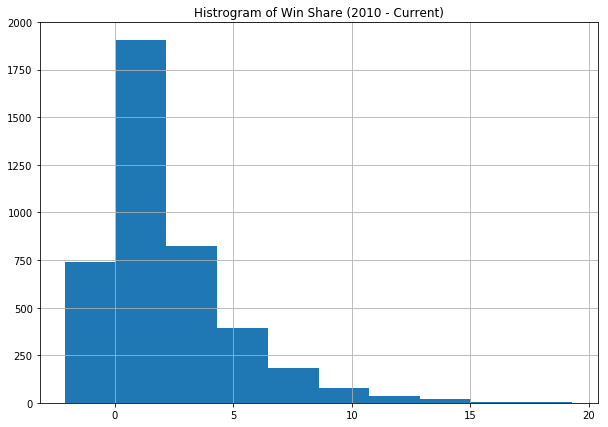

In [88]:
baseStats[(baseStats['Year'] > 2010)]['WS'].hist(figsize=(10,7))
plt.title("Histrogram of Win Share (2010 - Current)")

In [21]:
baseStats[(baseStats['Year'] > 2010)].head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
20501,20501,2011.0,Jeff Adrien,PF,24.0,GSW,23.0,0.0,196.0,11.3,...,0.579,23.0,35.0,58.0,10.0,4.0,5.0,9.0,28.0,57.0
20502,20502,2011.0,Arron Afflalo,SG,25.0,DEN,69.0,69.0,2324.0,13.6,...,0.847,45.0,206.0,251.0,168.0,34.0,31.0,71.0,153.0,867.0
20503,20503,2011.0,Maurice Ager,SG,26.0,MIN,4.0,0.0,29.0,10.1,...,NaN,0.0,2.0,2.0,1.0,1.0,0.0,4.0,4.0,15.0
20504,20504,2011.0,Alexis Ajinca,C,22.0,TOT,34.0,2.0,340.0,12.2,...,0.722,17.0,61.0,78.0,10.0,11.0,19.0,18.0,73.0,143.0
20505,20505,2011.0,Alexis Ajinca,C,22.0,DAL,10.0,2.0,75.0,12.8,...,0.667,5.0,12.0,17.0,2.0,3.0,5.0,1.0,13.0,29.0


#### Histograms can be used to view the distribution of key numeric features

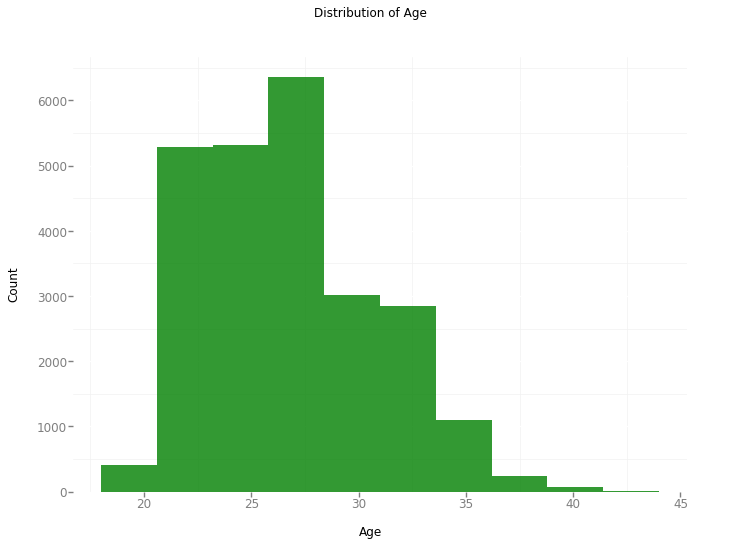

<ggplot: (-9223371921186050209)>

In [27]:
from ggplot import ggplot
from ggplot import *
ggplot(aes(x='Age'), data=baseStats) + \
        geom_histogram(alpha = 0.8,fill = 'green') +\
        ylab("Count") +\
        ggtitle('Distribution of Age') +\
        theme_bw()

#### Query Season and Team to Extract Full Team Stats

In [40]:
baseStats[(baseStats['Year']==2016) & (baseStats['Tm']=="NYK")]

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
23520,23520,2016.0,Arron Afflalo,SG,30.0,NYK,71.0,57.0,2371.0,10.9,...,0.840,23.0,243.0,266.0,144.0,25.0,10.0,82.0,142.0,909.0
23528,23528,2016.0,Lou Amundson,PF,33.0,NYK,29.0,0.0,204.0,6.7,...,0.519,23.0,26.0,49.0,12.0,6.0,7.0,15.0,44.0,52.0
23538,23538,2016.0,Thanasis Antetokounmpo,SF,23.0,NYK,2.0,0.0,6.0,32.9,...,NaN,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,6.0
23539,23539,2016.0,Carmelo Anthony,SF,31.0,NYK,72.0,72.0,2530.0,20.3,...,0.829,98.0,458.0,556.0,299.0,62.0,38.0,176.0,180.0,1573.0
23597,23597,2016.0,Jose Calderon,PG,34.0,NYK,72.0,72.0,2024.0,12.3,...,0.875,22.0,207.0,229.0,298.0,63.0,7.0,87.0,135.0,544.0
23655,23655,2016.0,Cleanthony Early,SF,24.0,NYK,17.0,2.0,154.0,2.2,...,0.750,4.0,22.0,26.0,6.0,2.0,3.0,9.0,16.0,31.0
23681,23681,2016.0,Jimmer Fredette,SG,26.0,NYK,2.0,0.0,5.0,47.4,...,0.800,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0
23686,23686,2016.0,Langston Galloway,PG,24.0,NYK,82.0,7.0,2033.0,11.7,...,0.754,43.0,245.0,288.0,207.0,77.0,22.0,61.0,177.0,625.0
23703,23703,2016.0,Jerian Grant,PG,23.0,NYK,76.0,6.0,1265.0,11.2,...,0.780,23.0,120.0,143.0,177.0,50.0,10.0,87.0,97.0,426.0
23847,23847,2016.0,Robin Lopez,C,27.0,NYK,82.0,82.0,2219.0,17.6,...,0.795,268.0,334.0,602.0,114.0,16.0,129.0,133.0,182.0,842.0


---
## Salary Data

In [89]:
salary = pd.read_csv('salaries.csv',sep=',')
salary.head()

,player,salary,season_end,season_start,team,team_name
0,Moses Malone,2406000,1991,1990,ATL,Atlanta Hawks
1,Dominique Wilkins,2065000,1991,1990,ATL,Atlanta Hawks
2,Jon Koncak,1550000,1991,1990,ATL,Atlanta Hawks
3,Doc Rivers,895000,1991,1990,ATL,Atlanta Hawks
4,Rumeal Robinson,800000,1991,1990,ATL,Atlanta Hawks


### *Descriptive Statistics*
* Average Salary by Season
* Histogram of $M per Win Share (requires joining to salaries to statistics)

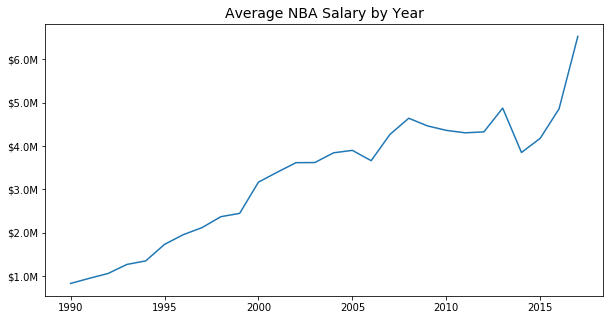

In [105]:
salaryGroup = salary.groupby(salary['season_start'],as_index=False).mean()

def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)
formatter = FuncFormatter(millions)
fig, ax = plt.subplots(figsize=(10,5))
ax.yaxis.set_major_formatter(formatter)
plt.plot(salaryGroup['season_start'],salaryGroup['salary'])
plt.title("Average NBA Salary by Year",fontsize=14)
plt.show()
plt.figure(figsize=(10,10))


In [107]:
newStats = baseStats[(baseStats['Year']>=2005)]

In [110]:
newStats['Player'] = newStats['Player'].map(lambda x: x.lower())

C:\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [111]:
newStats.head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
17076,17076,2005.0,shareef abdur-rahim,PF,28.0,POR,54.0,49.0,1867.0,18.7,...,0.866,123.0,269.0,392.0,111.0,49.0,26.0,117.0,150.0,909.0
17077,17077,2005.0,cory alexander,SG,31.0,CHA,16.0,1.0,201.0,8.8,...,0.750,8.0,21.0,29.0,37.0,9.0,1.0,19.0,29.0,49.0
17078,17078,2005.0,malik allen,PF,26.0,TOT,36.0,1.0,519.0,14.2,...,0.929,40.0,59.0,99.0,18.0,9.0,22.0,18.0,53.0,194.0
17079,17079,2005.0,malik allen,PF,26.0,MIA,14.0,0.0,248.0,13.6,...,0.929,24.0,28.0,52.0,11.0,4.0,11.0,11.0,29.0,83.0
17080,17080,2005.0,malik allen,PF,26.0,CHA,22.0,1.0,271.0,14.8,...,0.929,16.0,31.0,47.0,7.0,5.0,11.0,7.0,24.0,111.0


In [133]:
newStats['Year'] = newStats['Year'].map(lambda x: int(x))
newStats2 = newStats.set_index(['Player','Year','Tm']).reset_index()

C:\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [134]:
salary.head()
salary['player'] = salary['player'].map(lambda x: x.lower())
salary['season_start'] = salary['season_start'].map(lambda x: round(int(x),1))

newSal = salary.set_index(['player','season_start','team']).reset_index()

In [136]:
updatedNew = pd.merge(newStats2,newSal,left_on=['Player','Year','Tm'], right_on=['player','season_start','team'])

In [149]:
updatedNew['$M per WS'] = (updatedNew['salary']/updatedNew['WS'])/1000000

Text(0.5,1,'Histrogram of $M per Win Share')

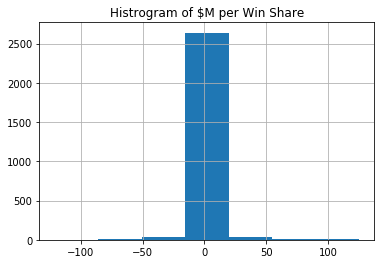

In [155]:
updatedNew2 = updatedNew[np.isfinite(updatedNew['$M per WS'])]
updatedNew2['$M per WS'].hist(bins=7)
plt.title("Histrogram of $M per Win Share")

In [148]:
updatedNew2[['WS','salary','$M per WS']].head()

,WS,salary,$M per WS
0,2.7,969696,3.591467e+05
1,4.5,3500000,7.777778e+05
2,1.3,9093000,6.994615e+06
3,-0.1,7900000,-7.900000e+07
4,2.2,1035000,4.704545e+05


In [156]:
updatedNew2['$M per WS'].describe()

count    2737.000000
mean        2.350278
std        10.017860
min      -121.000000
25%         0.800000
50%         1.480263
75%         2.759063
max       125.000000
Name: $M per WS, dtype: float64